# YOLO v7 Training and Inference on Custom Dataset

## 1. Install Dependencies and Set Up Environment

This section assumes that the `yolov7` environment has been created as follows:

```bash
# Crate env: requirements in conda.yaml
# This packages are the basic for Pytorch-CUDA usage
# HOWEVER, we need to install more later on
# when we clone and use the  original YOLO v7 repo
conda env create -f conda.yaml
conda activate yolov7

# Pytorch: Windows + CUDA 11.7
# Update your NVIDIA drivers: https://www.nvidia.com/Download/index.aspx
# I have version 12.1, but it works with older versions, e.g. 11.7
# Check your CUDA version with: nvidia-smi.exe
conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

# Pytorch: Mac / Windows CPU
python -m pip install torch torchvision torchaudio
```

### GPU

In [1]:
# Check GPUs
!nvidia-smi

Mon May  8 10:09:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA T500                   WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               N/A /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Check that the GPU can be connected/accessed correctly
import os
import torch
import torchvision

In [3]:
# If you are running this notebook locally
# set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [4]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 2
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.6014, 0.5259, 0.4306],
        [0.8409, 0.8252, 0.6665],
        [0.6248, 0.7593, 0.3523],
        [0.7337, 0.7629, 0.9790],
        [0.7688, 0.3467, 0.4424]])


### YOLOv7 Repository

In [5]:
# Download/clone YOLOv7 repository and install its (additional) requirements
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

C:\Users\Mikel\git_repositories\detection_segmentation_pytorch\03_yolo_v7_tutorial\lab\yolov7


fatal: destination path 'yolov7' already exists and is not an empty directory.


### Additional Requirements

The YOLOv7 `requirements.txt` has some dependencies which are commented out. Here, we install them manually/explicitly.

In [6]:
!pip install roboflow

## 2. Download Custom Dataset from Roboflow

In [7]:
# Note we are inside the YOLO repo folder
# We dowload our ROboflow dataset there
%pwd

'C:\\Users\\Mikel\\git_repositories\\detection_segmentation_pytorch\\03_yolo_v7_tutorial\\lab\\yolov7'

### Get the Dataset

In [8]:
# Get API key:
# Projects > Settings > Roboflow API: Private API Key, Show
# Do not publish this key
# Alternatively, persist in local file, don't commit,
# and load from file
with open('../roboflow.key', 'r') as file:
    api_key = file.read().strip()

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("mikel-sagardia-tknfd").project("basic-object-detection-qkmda")
dataset = project.version(1).download("yolov7")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Basic-Object-Detection-1 in yolov7pytorch:: 100%|█| 178/178 [00:00<00:00, 1407.41it/s


### Check the Dataset Structure

In [47]:
# Dataset location
print(dataset.location)

C:\Users\Mikel\git_repositories\detection_segmentation_pytorch\03_yolo_v7_tutorial\lab\yolov7\Basic-Object-Detection-1


The Roboflow `dataset` object contains several information on the dataset. We will pass the `dataset.location/data.yaml` file to the `train.py` scrip, which contains the following:

```yaml
names:
- ball
- cup
- lotion
nc: 3
roboflow:
  license: CC BY 4.0
  project: basic-object-detection-qkmda
  url: https://universe.roboflow.com/mikel-sagardia-tknfd/basic-object-detection-qkmda/dataset/1
  version: 1
  workspace: mikel-sagardia-tknfd
test: ../test/images
train: Basic-Object-Detection-1/train/images
val: Basic-Object-Detection-1/valid/images
```

Apparently, the `roboflow` key is not that important, but the rest of the keys are: `names`, `nc` (number of classes), `test`, `train`, `val`; thus, we can create a similar dataset strucure with another tool than Roboflow. In particular, the image split folder contain:

- unique image names for image files, e.g.,: `img_xxx.jpg`
- a folder `labels` with a TXT for each unique image: `img_xxx.txt`

The `img_xxx.txt` files contain a list of bounding boxes in the image:

```
2 0.56015625 0.4421875 0.140625 0.26875
1 0.5234375 0.76875 0.340625 0.4625
0 0.8421875 0.60625 0.2296875 0.28125
```

The format is the following (coordinates scaled to the image size):

```
class_id x_center, y_center, width, height
```

Thus, the dataset structure, is the following:

```
dataset/
├── test/
│   ├── images/
│   │   └── img_XX1.jpg
│   ├── blabels/
│        └── img_XX1.txt
├── train/
└── val/
```

**BUT**, in another example shown in this [blog post by LearnOpenCV](https://learnopencv.com/fine-tuning-yolov7-on-custom-dataset/), the dataset structure seems to be different:

```
dataset/
├── images
│   ├── test/
│   │   └── img_XX1.jpg
│   ├── train/
│   └── valid/
└── labels
    ├── test/
    │   └── img_XX1.txt
    ├── train/
    └── valid/
```

## 3. Training

### Get Pre-Trained Weights

In [10]:
# Note we are still in the YOLO repo folder
# We downloaded the pre-trained weights there
%pwd

'C:\\Users\\Mikel\\git_repositories\\detection_segmentation_pytorch\\03_yolo_v7_tutorial\\lab\\yolov7'

In [ ]:
# Download COCO starting checkpoint f the YOLO model to fine tune
# We are going to upload these weights to fine tune with the training script
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

### Train

In [48]:
import os
import sys
# This variable switches off a warning of OpenMP
if sys.platform == "win32":
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [38]:
# TRAINING SCRIPT
# NOTES:
# - On Windows, unfortunately we don't have the realtime output
#     Possible fix: https://discourse.jupyter.org/t/how-to-show-the-result-of-shell-instantly/8947/10
# - Before running, we need to log in to wandb
#     >> wandb login
# - The fine-tuned model will be saved by default to
#     runs/train/expXX/weights/best.pt
# - The training metrics and parameters/config are in
#     runs/train/expXX
# - Check all the possible arguments of train.py!
# - We get a wandb experiment tracking report link, check it!
!python train.py --batch 16 \
                 --workers 8 \
                 --epochs 500 \
                 --data {dataset.location}/data.yaml \
                 --weights 'yolov7_training.pt' \
                 --img 640 640 \
                 --device 0 \
                 --cfg cfg/training/yolov7.yaml


autoanchor: Analyzing anchors... anchors/target = 4.69, Best Possible Recall (BPR) = 1.0000
                 all           7          20       0.337        0.19     0.00327    0.000667
                 all           7          20      0.0022        0.19     0.00165     0.00037
                 all           7          20     0.00344        0.19     0.00175     0.00037
                 all           7          20     0.00282       0.143     0.00265    0.000348
                 all           7          20     0.00167       0.333     0.00234    0.000306
                 all           7          20     0.00222       0.286     0.00201    0.000229
                 all           7          20     0.00351       0.389     0.00219    0.000255
                 all           7          20     0.00214       0.286     0.00166    0.000229
                 all           7          20     0.00212       0.381     0.00193     0.00036
                 all           7          20     0.00124       0.333  

YOLOR  v0.1-122-g3b41c2c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12287.5MB)

Namespace(weights="'yolov7_training.pt'", cfg='cfg/training/yolov7.yaml', data='C:\\Users\\Mikel\\git_repositories\\detection_segmentation_pytorch\\03_yolo_v7_tutorial\\lab\\yolov7\\Basic-Object-Detection-1/data.yaml', hyp='data/hyp.scratch.p5.yaml', epochs=500, batch_size=16, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='exp', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs\\train\\exp14', total_batch_size=16)
tensorboard: Start with 'tensorboard --logdir runs/train', view a

## 4. Test Results



In [41]:
# DETECT SCRIPT
# Notes:
# - We are passing the dataset test folder
# - Use the desired trained model path, e.g.
#     runs/train/expXX/weights/best.pt
# - The detected images & labels will be saved by default to
#     runs/detect/expXX/
# - Check all possible arguments of detect.py!
!python detect.py --weights runs/train/exp14/weights/best.pt \
                  --conf 0.4 \
                  --img-size 640 \
                  --source {dataset.location}/test/images \
                  --view-img \
                  --save-txt \
                  --save-conf

Namespace(weights=['runs/train/exp14/weights/best.pt'], source='C:\\Users\\Mikel\\git_repositories\\detection_segmentation_pytorch\\03_yolo_v7_tutorial\\lab\\yolov7\\Basic-Object-Detection-1/test/images', img_size=640, conf_thres=0.4, iou_thres=0.45, device='', view_img=True, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 ball, 1 cup, 1 lotion, Done. (42.7ms) Inference, (8.1ms) NMS
 The image with the result is saved in: runs\detect\exp10\img16_png.rf.cf285e0ab68804f5ebabde4b2ba7be7a.jpg
1 ball, 1 cup, Done. (20.1ms) Inference, (1.0ms) NMS
 The image with the result is saved in: runs\detect\exp10\img26_png.rf.d279c2408cb28c4c4da278648df63b3d.jpg
1 ball, 1 cup, 1 lotio

YOLOR  v0.1-122-g3b41c2c torch 1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12287.5MB)
                                             CUDA:1 (NVIDIA T500, 4095.75MB)

C:\Users\Mikel\.conda\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS


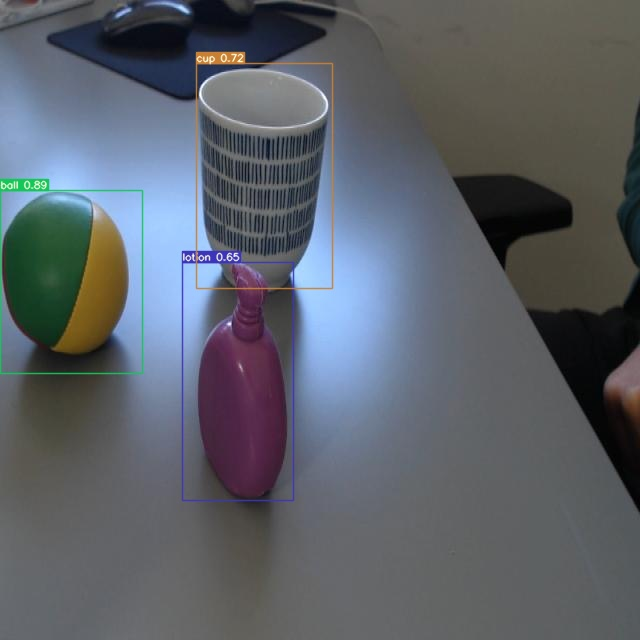

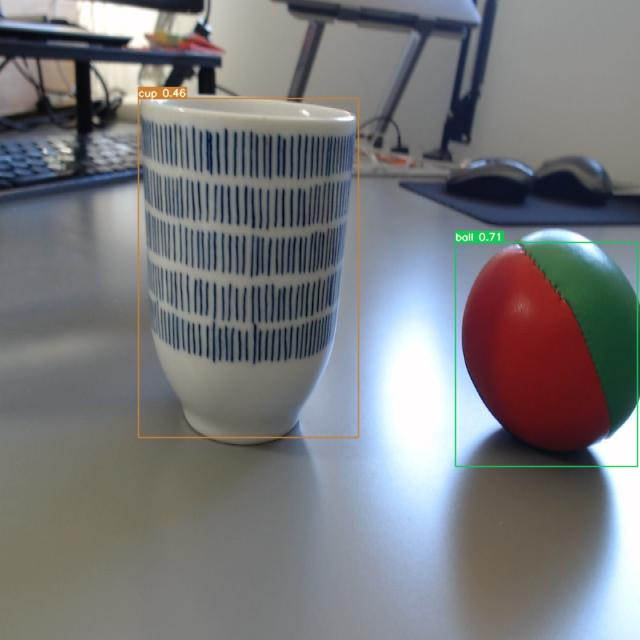

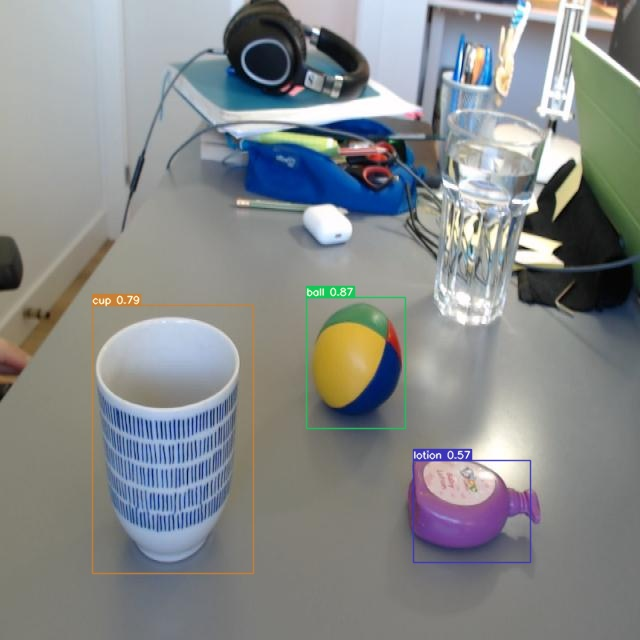

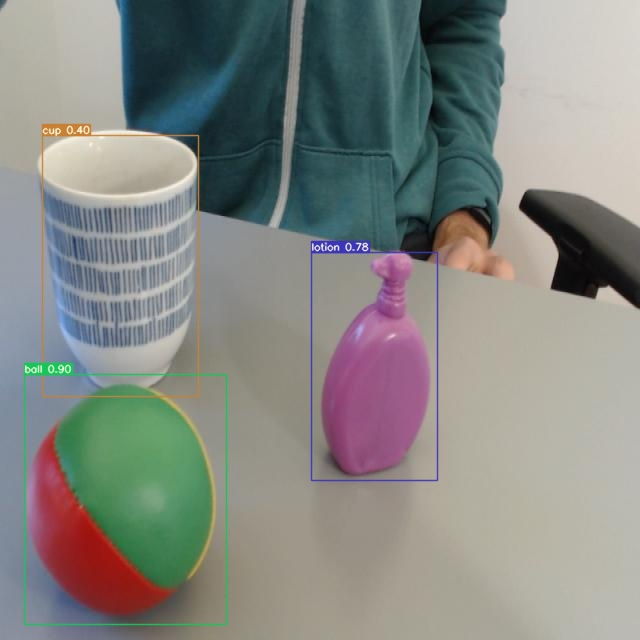

In [43]:
# Display inference on ALL test images
import glob
from IPython.display import Image, display

i = 0
limit = 10 # max images to print
# Note: use the path where the test images were saved!
for imageName in glob.glob('runs/detect/exp10/*.jpg'): # assuming JPG
    if i < limit:
        display(Image(filename=imageName))
        print("\n")
    i = i + 1

## 5. Export the Model

If we export the model (currently a Pytorch model) to the standard [ONNX](https://onnx.ai/), we can use it to perform live inference with OpenCV. To that end, we need to install some additional packages.

###  ONNX: for inference and deployment

In [49]:
!pip install --upgrade setuptools pip --user
!pip install protobuf<4.21.3
!pip install onnx>=1.9.0
!pip install onnxruntime
!pip install onnxruntime-gpu
!pip install onnx-simplifier>=0.3.6 --user

The system cannot find the file specified.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [52]:
# Select the model exp version we'd like to export to ONNX
# The ONNX model is exported to the same folder as the file best.onnx
!python export.py --weights runs/train/exp14/weights/best.pt \
                  --grid \
                  --end2end \
                  --simplify \
                  --topk-all 100 \
                  --iou-thres 0.45 \
                  --conf-thres 0.2 \
                  --img-size 640 640 \
                  --max-wh 640
# For onnxruntime, you need to specify this last value as an integer,
# when it is 0 it means agnostic NMS, otherwise it is non-agnostic NMS

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='runs/train/exp14/weights/best.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=640, topk_all=100, iou_thres=0.45, conf_thres=0.2, device='cpu', simplify=True, include_nms=False, fp16=False, int8=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse

Starting TorchScript export with torch 1.13.0+cu117...
TorchScript export success, saved as runs/train/exp14/weights/best.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.13.0+cu117...
TorchScript-Lite export success, saved as runs/train/exp14/weights/best.torchscript.ptl

Starting ONNX export with onnx 1.14.0...
onnxruntime

Starting to simplify ONNX...
ONNX export success, saved as runs/train/exp14/weights/best.onnx

Export complete (26.79s). Visualize with https://gi

YOLOR  v0.1-122-g3b41c2c torch 1.13.0+cu117 CPU

C:\Users\Mikel\.conda\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients, 103.2 GFLOPS
C:\Users\Mikel\git_repositories\detection_segmentation_pytorch\03_yolo_v7_tutorial\lab\yolov7\models\yolo.py:150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
C:\Users\Mikel\git_repositories\detection_segmentation_pyt

## 6. Deployment

Files we need:

- If we want to deploy using the model trained on **Roboflow** (i.e., remotely using the Roboflow API), we just need to access the Roboflow interface, without downloading any model.
- If we want to deploy the **Pytorch** model (locally) we need `.../best.pt`
- If we want to deploy the **ONNX** model (e.g., on locally, OpenCV DNN) we need `.../best.onnx`

### Roboflow Static Deployment: API

The following code snippet is from [`detect_roboflow.py`](detect_roboflow.py). In it, we basically connect to our Roboflow project model and use the API to perform an inference on an image.

Additionally, although it is not implemented here, we can perform **active learning**:

- We track our inferences: we check the values of the confidences.
- If a predicted confidence is inside a predefined range (e.g., very low, high, etc.), we upload the image to the project dataset: `project.upload()`.
- Then, in the Roboflow web UI, we can label the uploaded images.
- That way, our model becomes better.

More on active learning: [Implementing Active Learning](https://help.roboflow.com/guides/implementing-active-learning).

In [60]:
%cd ..

C:\Users\Mikel\git_repositories\detection_segmentation_pytorch\03_yolo_v7_tutorial\lab


In [61]:
%pwd

'C:\\Users\\Mikel\\git_repositories\\detection_segmentation_pytorch\\03_yolo_v7_tutorial\\lab'

In [63]:
from roboflow import Roboflow

# Get API key:
# Projects > Settings > Roboflow API: Private API Key, Show
# Do not publish this key
# Alternatively, persist in local file, don't commit,
# and load from file
with open('roboflow.key', 'r') as file:
    api_key = file.read().strip()

# Download model
rf = Roboflow(api_key=api_key)
project = rf.workspace("mikel-sagardia-tknfd").project("basic-object-detection-qkmda")
# Check in the Roboflow web UI rge model version we'd like
# This is a Roboflow model object, which in reality points to the Roboflow API
model = project.version(1).model

# Infer on a local image
img_url = "yolov7/Basic-Object-Detection-1/test/images/img9_png.rf.c3bea63eb9645df2c0d196d74b1550d5.jpg"
print(model.predict(img_url, confidence=40, overlap=30).json())
# Visualize/save the prediction
model.predict(img_url, confidence=40, overlap=30).save("test_prediction.jpg")

# Infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 122.5, 'y': 499.5, 'width': 201.0, 'height': 255.0, 'confidence': 0.902337908744812, 'class': 'ball', 'image_path': 'yolov7/Basic-Object-Detection-1/test/images/img9_png.rf.c3bea63eb9645df2c0d196d74b1550d5.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 379.0, 'y': 361.5, 'width': 140.0, 'height': 203.0, 'confidence': 0.8436849117279053, 'class': 'lotion', 'image_path': 'yolov7/Basic-Object-Detection-1/test/images/img9_png.rf.c3bea63eb9645df2c0d196d74b1550d5.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 119.5, 'y': 256.0, 'width': 179.0, 'height': 282.0, 'confidence': 0.7519652843475342, 'class': 'cup', 'image_path': 'yolov7/Basic-Object-Detection-1/test/images/img9_png.rf.c3bea63eb9645df2c0d196d74b1550d5.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '640', 'height': '640'}}


In [66]:
# This is a Roboflow model object, which in reality points to the Roboflow API
print(model)

{
  "id": "basic-object-detection-qkmda/1",
  "name": "Basic Object Detection",
  "version": "1",
  "classes": null,
  "overlap": 30,
  "confidence": 40,
  "stroke": 1,
  "labels": false,
  "format": "json",
  "base_url": "https://detect.roboflow.com/"
}


### Pytorch Online Webcam Deployment

The custom-made file [`yolov7/detect_pytorch_webcam_opencv.py`](yolov7/detect_pytorch_webcam_opencv.py) is a modified version of the original [`detect.py`](yolov7/detect.py) which enables online webcam inference.

The file uses the `best.pt` we want; we access webcam images and show inferences using OpenCV.

I was able to run this script using the NVIDIA eGPU.

**WARNING**: the code needs to cleaning up, refactoring, etc. Notice the different hard-coded parameters.

### ONNX Deployment

The custom file [`detect_onnx_webcam_opencv.py`](detect_onnx_webcam_opencv.py) is a modified version of the original [`detect.py`](yolov7/detect.py) which enables online webcam inference using the exported ONNX model.

The file uses the `best.onnx` we want; we access webcam images and show inferences using OpenCV, and the inference itself is done with OpenCV, too, leveraging the DNN module.

Unfortunately, I was able to run this script only with the CPU option, which results in a much slower inference (1 FPS). I think that the GPU issue is related to some ONNX dependency/version incompatibility: [CUDAExecutionProvider Not Available](https://github.com/microsoft/onnxruntime/issues/7748).

**WARNING**: the code needs to cleaning up, refactoring, etc. Notice the different hard-coded parameters.